# Face Generator

## Project

Imagine that you worked for a movie producer and your job was to design characters for a next movie. Based on the script, you can probably imagine personality and style of each person. The only thing that left to do is to draw them. This step is probably the hardest and it takes a lot of sketches to finally come up with a good one.

But what if the computer drew new faces for you and you only needed to select the perfect one. You probably agree with me that it would be much easier than sketching. Well... I am going to make your and other character designers' lifes easier by building such a generator!

## Outline

I start with training a discriminator whose job is to distinguish between real images, coming from a training set, and fake ones coming out of the generator. When it learns how to recognize a fake image, I start to train the generator. It slowly learns to produce images of higher quality. It knows that it moves in a right direction, when more of its images are classified as real by the discriminator. This is basically how you train a GAN. At the end, you only keep the generator.

I follow this framework and train the discriminator using a dataset of face images. This way, it learns to recognize genuine profile pictures. From this point, generator will try its best to produce an image that would pass as a real one. So it has no choice but to learn how to create a realistic face image.

## Imports

In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests

%matplotlib inline

import torch
from torchvision import datasets
from torchvision import transforms

## Load the data

I will use the CelebA dataset that contains around 200,000 annotated images. You don't need to use the annotations. The discriminator will classify images as real or fake by just looking at them. You also want the network to focus only on what is important, so the faces should be cropped out.

I'm going to load a subset of 90,000 pictures that were initially transformed. They contain faces only and are of the same size (64, 64, 3).

In [2]:
def get_dataloader(batch_size, image_size, data_dir = 'data/'):
    '''Supplies batches of data for training.
    
    Args:
        batch_size(int): number of images in a batch
        img_size(int): image width or height
        data_dir(string): directory with training images
    
    Returns: DataLoader object
    '''
    
    # Resize each image and convert batchers to tesnsors
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    # Read transformed image data
    dataset = datasets.ImageFolder(root = data_dir, 
                                   transform = transform)
    
    data_loader = torch.utils.data.DataLoader(dataset = dataset,
                                              batch_size = batch_size,
                                              shuffle = True)
    
    return data_loader


In [3]:
# Data loader parameters
batch_size = 128
img_size = 32

# Run the code
celeba_train_loader = get_dataloader(batch_size, img_size)

Let's see how the loaded images look like.

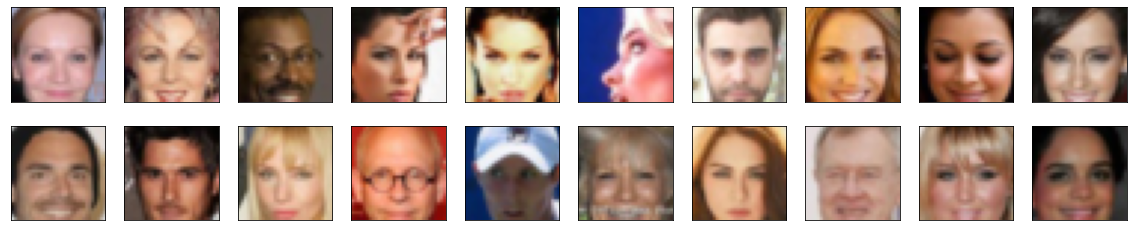

In [4]:
def imshow(img):
    '''Takes in image tensor and displays it'''
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

# Get a batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# Plot 20 images images from the batch
fig = plt.figure(figsize = (20, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size / 2, idx + 1, xticks = [], yticks = [])
    imshow(images[idx])

Everything seems right. The images are squares and contain just the faces.

### Rescaling

Right now, the images are in a range of 0 to 1 but they need to be in [-1, 1]. You may wonder why. Discriminator will have to work both with training images and generated ones. Since the generator uses `tanh` activation and outputs images in a range of [-1, 1], it will be easier to rescale the training images in this way.

I'm going to write a rescaling function that I will use later.

In [5]:
def scale(x, feature_range = (-1, 1)):
    '''Takes in an image x in a range [0, 1] and returns that image rescaled to given range'''
    # Scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    
    return x

In [6]:
# Test it on a single image
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9686)
Max:  tensor(0.9294)


I also made a little test and applied it to a sample image. Minimum value is greater than -1 and maximum is below 1. It works correctly.

# Define the GAN

GAN consists of two individual neural networks, a discriminator and a generator.

### Discriminator

Let's start with the discriminator. It's going to be a CNN but without pooling layers a usual. Its job is to take in an input image (32, 32, 3) and output 1 if the image is real or 0 in the other case.

I won't use maxpooling but you still want to downsample an image. You can do it by creating a convolutional layer with a kernel of (4, 4) and a stride of 2. It is going to reduce the image size by 2. That being said, I will use just 3 layers. It will take an input image from (32, 32) -> (16, 16) -> (8, 8) -> (4, 4). I don't want to downsample it more than that, because smaller image could possibly loose too much of the original info.

The output needs to be an integer (a single score that will be later translated into probability). So at the last layer I will downsample the image to (1, 1, 1) and reshape it into an integer value.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, 
         out_channels, 
         kernel_size, 
         stride = 2, 
         padding = 2, 
         batch_norm = True):
    '''Create a convolutional layer, with optional batch normalization.'''
    
    # Conv layer
    layers = []
    conv_layer = nn.Conv2d(in_channels = in_channels, 
                           out_channels = out_channels, 
                           kernel_size = kernel_size, 
                           stride = stride, 
                           padding = padding, 
                           bias = False)
    layers.append(conv_layer)
    
    # Optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [8]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        '''Initialize layers.
        
        Args:
            conv_dim(int): number of feature maps in the first convolutional layer
        '''
        super(Discriminator, self).__init__()

        # Define convolutional layers
        self.conv1 = conv(in_channels = 3, 
                          out_channels = conv_dim, 
                          kernel_size = (4, 4), 
                          batch_norm = False) # (32, 32, 3) -> (16, 16, conv_dim)
        self.conv2 = conv(in_channels = conv_dim, 
                          out_channels = int(conv_dim / 2), 
                          kernel_size = (4, 4)) # (16, 16, conv_dim) -> (8, 8, conv_dim / 2)
        self.conv3 = conv(in_channels = int(conv_dim / 2), 
                          out_channels = int(conv_dim / 4), 
                          kernel_size = (4, 4)) # (8, 8, conv_dim / 2) -> (4, 4, conv_dim / 4)
        self.conv4 = conv(in_channels = int(conv_dim / 4), 
                          out_channels = 1, 
                          padding = 0,
                          kernel_size = (4, 4)) # (4, 4, conv_dim / 4) -> (1, 1, 1)
        

    def forward(self, x):
        '''Forward propagation.
        
        Args:
            x(Tensor): input of size (batch_size, 32, 32, 3)   
        
        Returns: logit values (batch_size, 1), score value for every observation in a batch
        '''
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        # Resize from (batch_size, 1, 1, 1) to (batch_size, 1)
        out = x.view(-1, 1)
        
        return out

# Test
tests.test_discriminator(Discriminator)

Tests Passed


### Generator

Generator takes in a vector from a latent space, which simply put is a random vector. Then it upsamples the input using transpose convolutional layers until it reaches the image size (32, 32, 3).

But you cannot simply pass into convolutional layers a 2D vector. You need to reshape it first into 3D. So at the beginning I'm going to use a fully-connected layer. It will take in a vector z and scale its length up so it can be easily reshaped into image of size (4, 4, x). And then will follow transpose convolutional layers.

In [9]:
def deconv(in_channels, out_channels, kernel_size, stride = 2, padding = 1, batch_norm = True):
    '''Create a transpose convolutional layer, with optional batch normalization'''
    
    # Transpose conv layer
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, 
                                     out_channels, 
                                     kernel_size, 
                                     stride, 
                                     padding, 
                                     bias = False))
    
    # Optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [10]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        '''Initialize layers.
        
        Args:
            z_size(int): length of the latent vector z
            conv_dim(int): number of feature maps passed into the last layer
        '''
        super(Generator, self).__init__()
        
        # Define fully-connected layer
        self.fc = nn.Linear(z_size, 4 * 4 * conv_dim * 4)

        # Define transpose convolutional layers
        self.deconv1 = deconv(in_channels = conv_dim * 4, 
                              out_channels = conv_dim * 2, 
                              kernel_size = (4, 4)) # (4, 4, conv_dim * 4) -> (8, 8, conv_dim * 2)
        self.deconv2 = deconv(in_channels = conv_dim * 2, 
                              out_channels = conv_dim, 
                              kernel_size = (4, 4)) # (8, 8, conv_dim * 2) -> (16, 16, conv_dim)
        self.deconv3 = deconv(in_channels = conv_dim, 
                              out_channels = 3, 
                              kernel_size = (4, 4),
                              batch_norm = False) # (16, 16, conv_dim) -> (32, 32, 3)
        

    def forward(self, x):
        '''Forward propagation.
        
        Args:
            x(Tensor): input of_size(batch_size, z_size)   
        
        Returns: tensor image of size (32, 32, 3)
        '''
        
        batch_size = x.shape[0]
        
        # Reshape the vector into 3D (batch_size, channels, h, w)
        x = self.fc(x) # (batch,size, z_len) -> (batch_size, conv_dim * 4, 4, 4)
        x = x.reshape(batch_size, -1, 4, 4)
        
        # Upscale
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        out = F.tanh(self.deconv3(x)) # tanh
        
        return out

# Test
tests.test_generator(Generator)

Tests Passed


/home/adam/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


### Weight initialization

You can always use custom weights initialization to improve model's performance. I am going to write a function for it here.

I will initialize weights with values from a normal distribution with mean 0 and standard deviation of 0.02, exactly like in the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf). To help with the coding task, I base my code on [this fragment](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) from CycleGAN Github repository. I want to apply this strategy to convolutional and linear layers, leaving batch normalization layers alone.


In [11]:
def weights_init_normal(m):
    '''Sets initial weights to convolutional and linear layers of a model.
    Takes the weights from a normal distribution N(0, 0.02).
    
    Args:
        m: a module or layer in a network   
    '''
    # Classname takes the form something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    mean = 0.0
    std_dev = 0.02
    
    # Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        # Normal initialization, N(0, 0.02)
        nn.init.normal_(m.weight.data, mean, std_dev)

        # Init bias with 0
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)    

### Build the model

Now I am going to write the code that intializes the disciminator with the generator and returns them. It will make use of input hyperparameters and apply the custom weight initialization that you saw before.

In [12]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # Init discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # Initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

### Define the model's hyperparameters

I am going to experiment with 3 parameter values. They are the length of vector z and the number of feature maps in both discriminator and generator.

In [13]:
# Hyperparameters
d_conv_dim = 8
g_conv_dim = 8
z_size = 32

# Build the model with them
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(4, 2, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(2, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

Generator(
  (fc): Linear(in_features=32, out_features=512, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

## Define loss functions

Total loss of the discriminator is the sum of two smaller losses, the one on real images and the other one on fakes.

Since the generator want to trick the discriminator into believing that created pictures are real, its loss is adversary. It means that you only need to flip the labels and you can use the same loss function.

I'm going to implement the functions using binary cross entropy. For real loss I'm going to use label smoothing. It changes the label from 1.0 to 0.9 and helps the discriminator to generalize better.

In [14]:
def real_loss(D_out, smooth = False):
    '''The measure of discriminator's error on real images.
    
    Args:
        D_out(tensor): discriminator logits

    Returns: real loss (int)
    '''
    # Label smoothing
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    
    # Numerically stable loss (with logits)
    criterion = nn.BCEWithLogitsLoss()
    
    # Calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''The measure of discriminator's error on fake images.
    
    Args:
        D_out(tensor): discriminator logits

    Returns: fake loss (int)
    '''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    
    # Calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss